# Import cell
Run the following cell to have all of the required package.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, t
import pandas as pd
import statsmodels.formula.api as smf
from datetime import timedelta
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_stat_map
from nilearn.glm import threshold_stats_img
from nilearn.image import mean_img
import nibabel as nib


%matplotlib inline

# Task 1 Generating the data

In [2]:
def rect(t,A=1,length=1):
    if t <= length:
        return A
    else:
        return 0.0

In [3]:
# General variables
duration_time = 60 # in minutes
TR = 2 # in sec
time_between_events = 8 # in sec
oversampling = 50

events = {'Face': {'Amplitude': 1, 'Time_stimulus': 2}, # in sec
          'Control': {'Amplitude': 0.3, 'Time_stimulus': 2}} # in sec

start = pd.to_datetime('00:00:00')

# Create a date range with a TR frequency
date_range = pd.date_range(start=start, end=start+timedelta(minutes=duration_time)-timedelta(seconds=TR/oversampling), freq=str(TR/oversampling)+'S')


# Create data to alternate between events
time_events = pd.date_range(start=start, end=start+timedelta(minutes=duration_time)-timedelta(seconds=time_between_events), freq=str(time_between_events)+'S')
list_events = [[list(events)[i % len(events)]] for i in range(len(time_events))]
events_df = pd.DataFrame(data=list_events, index=time_events, columns=["Events"])

# Create signals corresponding to events
bank_of_signals = dict()
for event in events:
    bank_of_signals[event] = []
    for t in np.arange(0, time_between_events, TR/oversampling):
        bank_of_signals[event].append(rect(t, A=events[event]['Amplitude'], length=events[event]['Time_stimulus']))
bank_of_signals['Idle'] = np.zeros(int(time_between_events * oversampling / TR)).tolist()
bank_of_signals['Intercept'] = np.ones(int(time_between_events * oversampling / TR)).tolist()
    
# Create signals
signal = np.array([])
for event in list_events:
    signal = np.append(signal, bank_of_signals[event[0]]) 
signal = pd.DataFrame(data=signal, index=date_range, columns=["Signal"])

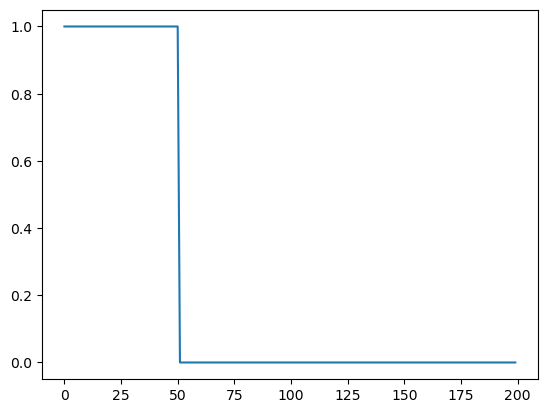

In [4]:
plt.plot(bank_of_signals[list(bank_of_signals.keys())[0]])
plt.show()

In [5]:
data = pd.concat([signal, events_df], axis=1)
data.loc[data["Events"].isnull(), "Events"] = "Idle"

data.head(20)

,Signal,Events
2023-10-17 00:00:00.000,1.0,Face
2023-10-17 00:00:00.040,1.0,Idle
2023-10-17 00:00:00.080,1.0,Idle
2023-10-17 00:00:00.120,1.0,Idle
2023-10-17 00:00:00.160,1.0,Idle
2023-10-17 00:00:00.200,1.0,Idle
2023-10-17 00:00:00.240,1.0,Idle
2023-10-17 00:00:00.280,1.0,Idle
2023-10-17 00:00:00.320,1.0,Idle
2023-10-17 00:00:00.360,1.0,Idle


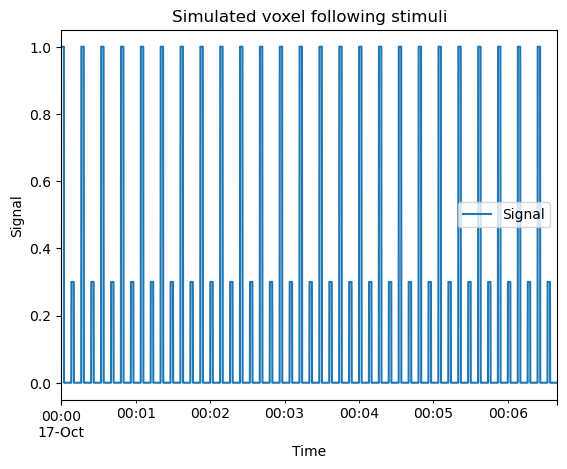

In [6]:
data.iloc[:200*oversampling].plot()
plt.title("Simulated voxel following stimuli")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.show()

# Task 2
Define the HRF. From course 2.1 slide 7, the HRF is the impulse response of $h_{\delta}$, and from the project file, we have $ h_{\gamma} = A ( \frac{t^{\alpha _1 -1} \beta _1^{\alpha_1} e^{\beta _1 t} }{\Gamma (\alpha _1)} -c \frac{t^{\alpha _2 -1} \beta _2^{\alpha_2} e^{\beta _2 t}}{\Gamma (\alpha _2)})$

with $\alpha_1 = 6$, $\alpha_2 = 16$, $\beta_1 = \beta_2 = 1$ and $c=⅙$

In [7]:
def h(A, t, alpha_1=6, alpha_2=16):
    beta_1 = 1
    beta_2 = 1
    c = 1/6
    
    h_part_1 = gamma.pdf(t, alpha_1, scale=1/beta_1)
    h_part_2 = c * gamma.pdf(t, alpha_2, scale=1/beta_2)
    h = A*(h_part_1 -h_part_2)
    
    return h

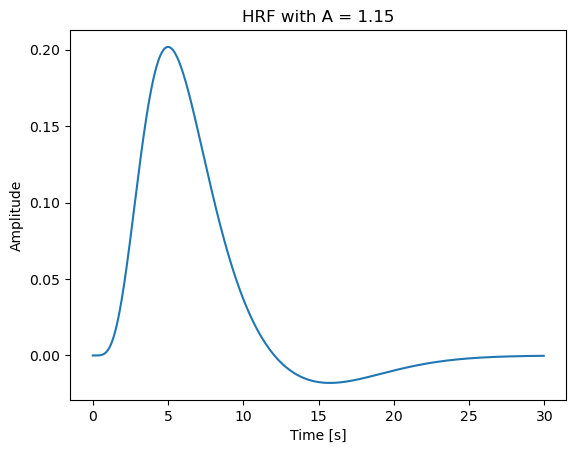

In [8]:
# Define our hrf
A = 1.15
time_len = 30

time = np.arange(0, time_len, TR / oversampling)

hrf = h(A, time)
plt.plot(time, hrf)
plt.title("HRF with A = {}".format(A))
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

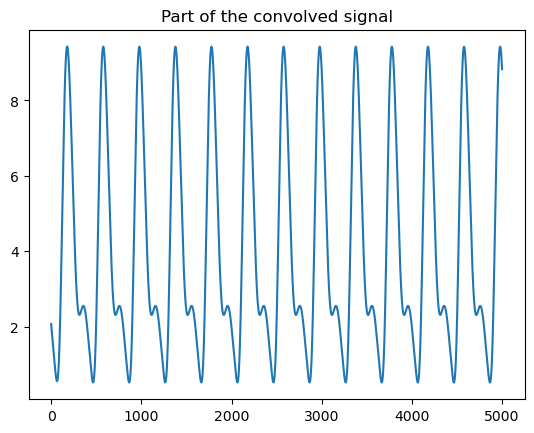

In [9]:
convolved_signal = np.convolve(hrf, data["Signal"], mode='same')
plt.plot(convolved_signal[:100*oversampling])
plt.title('Part of the convolved signal')
plt.show()

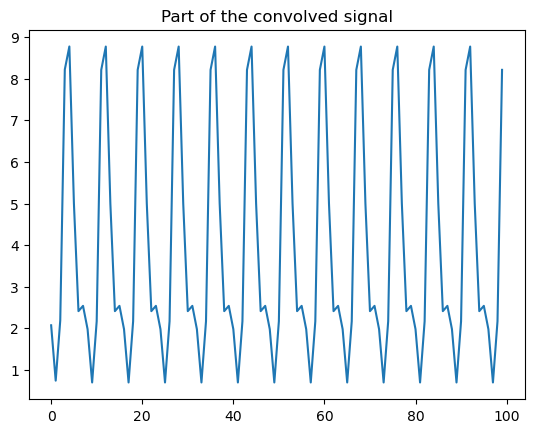

In [10]:
convolved_signal_undersampled = convolved_signal[::oversampling]
plt.plot(convolved_signal_undersampled[:100])
plt.title('Part of the convolved signal')
plt.show()

# Task 3

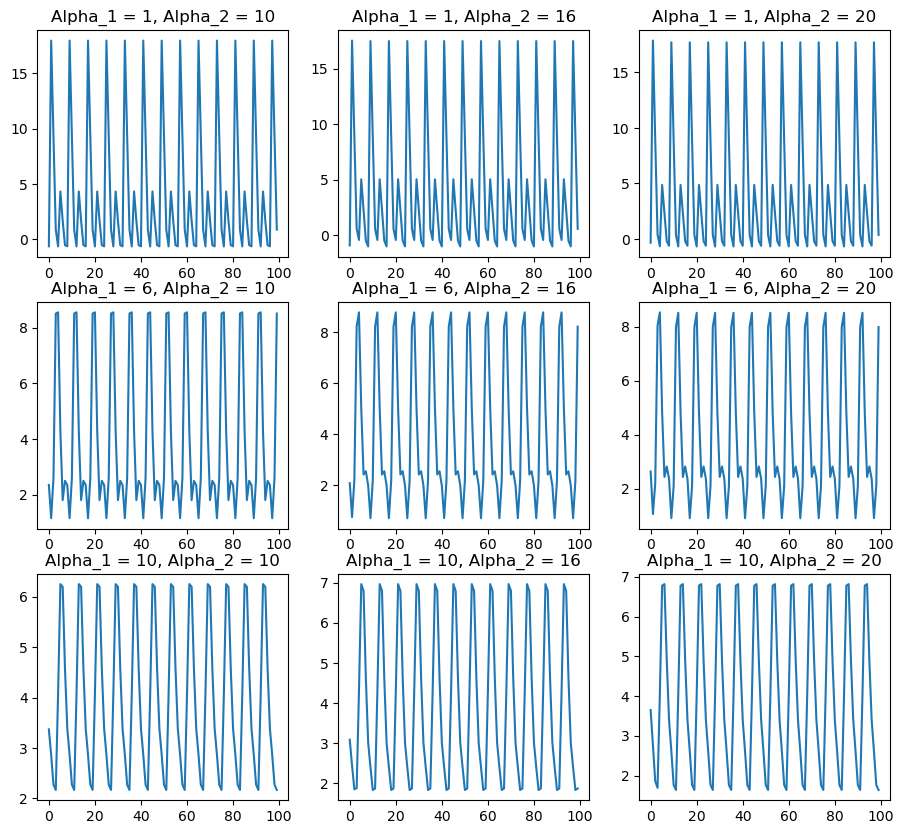

In [11]:
# Let's try to change the alphas

# alpha_1_values = range(5, 8)
# alpha_2_values = range(15, 18)
alpha_1_values = [1,6,10]
alpha_2_values = [10,16,20]

fig, axes = plt.subplots(3, 3, figsize=(11,10))

for i, alpha1 in enumerate(alpha_1_values):
    for j, alpha2 in enumerate(alpha_2_values):

        ax = axes[i, j]
        
        hrf2 = h(A, np.arange(0, time_len, TR / oversampling), alpha_1=alpha1, alpha_2=alpha2)
        convolved_signal2 = np.convolve(hrf2, data["Signal"], mode='same')
        
        ax.plot(convolved_signal2[:100*oversampling:oversampling])
        ax.set_title('Alpha_1 = {}, Alpha_2 = {}'.format(alpha1, alpha2))
        
plt.show()        

# Task 4

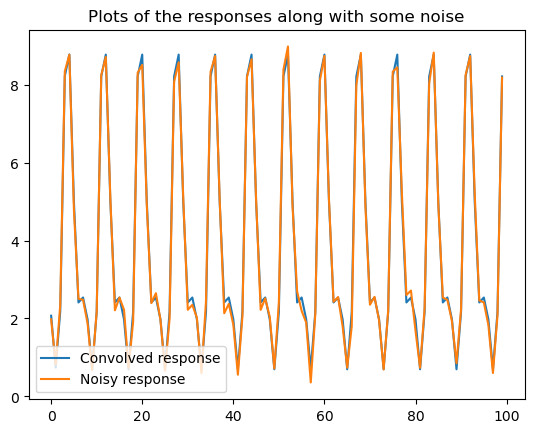

In [12]:
sigma = 0.15
noisy_response = convolved_signal_undersampled + np.random.normal(scale=sigma, size=len(convolved_signal_undersampled))
plt.plot(convolved_signal_undersampled[:100], label='Convolved response')
plt.plot(noisy_response[:100], label='Noisy response')
plt.legend()
plt.title('Plots of the responses along with some noise')
plt.show()

# Task 5

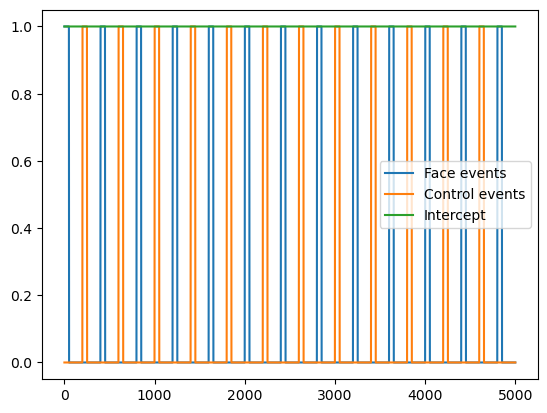

In [13]:
# First we create the vectors used for the design matrix
face_reg = np.array([])
control_reg = np.array([])
intercept = np.array([])

events_keys = list(events.keys())

for event in list_events:
    
    if event[0] == events_keys[0]:
        face_reg = np.append(face_reg, bank_of_signals[event[0]]) 
        control_reg = np.append(control_reg, bank_of_signals['Idle'])
    elif event[0] == events_keys[1]:
        control_reg = np.append(control_reg, bank_of_signals[event[0]])
        face_reg = np.append(face_reg, bank_of_signals['Idle']) 
    
    intercept = np.append(intercept, bank_of_signals['Intercept'])
    
face_reg = face_reg/events[events_keys[0]]['Amplitude']
control_reg = control_reg/events[events_keys[1]]['Amplitude']

plt.plot(face_reg[:100*oversampling], label='Face events')
plt.plot(control_reg[:100*oversampling], label='Control events')
plt.plot(intercept[:100*oversampling], label='Intercept')
plt.legend()
plt.show()

In [14]:
# Now we convolve these signals with the hrf and downsample
convolved_face_reg = np.convolve(hrf, face_reg, mode='same')
convolved_control_reg = np.convolve(hrf, control_reg, mode='same')
#convolved_intercept = np.convolve(hrf, intercept)

ds_face_reg = convolved_face_reg[::oversampling]
ds_control_reg = convolved_control_reg[::oversampling]
ds_intercept_reg = intercept[::oversampling]

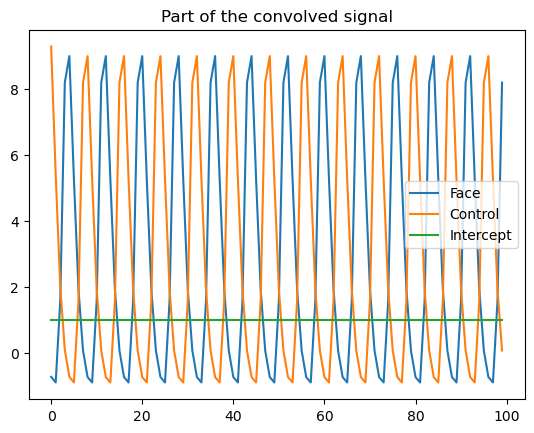

In [15]:
plt.plot(ds_face_reg[:100], label='Face')
plt.plot(ds_control_reg[:100], label='Control')
plt.plot(ds_intercept_reg[:100], label='Intercept')
plt.legend()
plt.title('Part of the convolved signal')
plt.show()

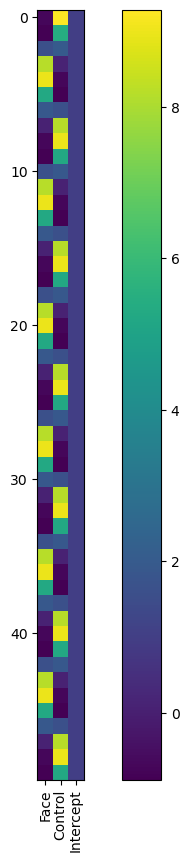

In [16]:
# Create the matrix out of these vectors
design_matrix = np.column_stack((ds_face_reg, ds_control_reg, ds_intercept_reg))

plt.figure(figsize=(10,10))
plt.imshow(design_matrix[:50,:])
plt.xticks(np.arange(0,3), ['Face', 'Control', 'Intercept'])
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

# Task 6

In [17]:
design_matrix_star = np.matmul(np.linalg.inv(np.matmul(np.transpose(design_matrix),design_matrix)), np.transpose(design_matrix))
b_estimate = np.matmul(design_matrix_star, noisy_response) 

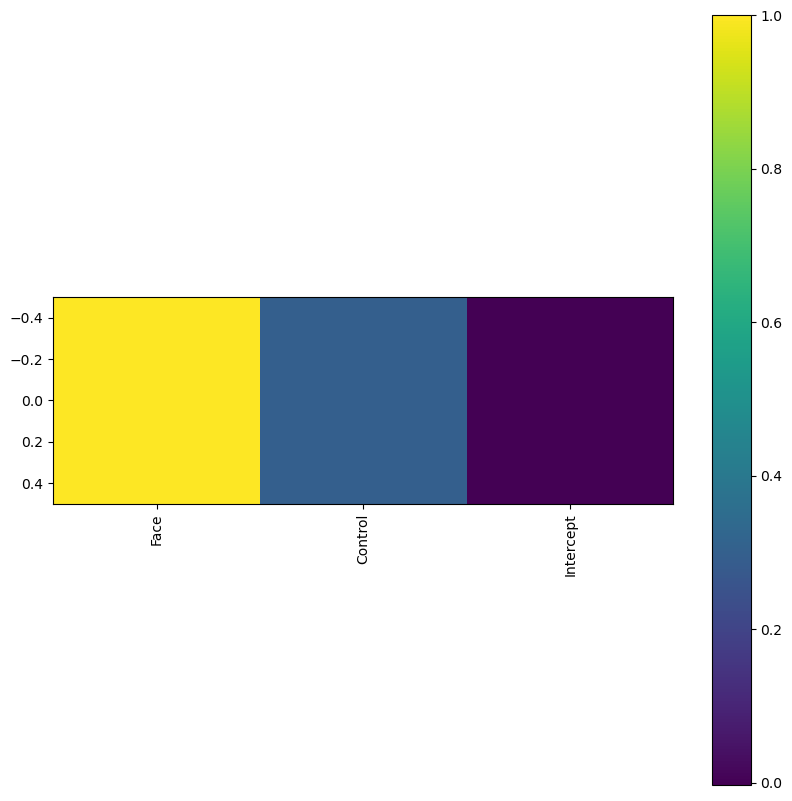

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(b_estimate.reshape(1,3))
plt.xticks(np.arange(0,3), ['Face', 'Control', 'Intercept'])
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

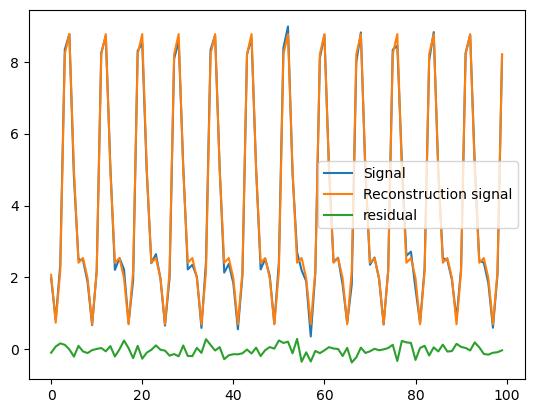

Max residual value :  0.514385099932694  Min residual value :  -0.5527671026694243  Mean residual value :  -2.4054832200211726e-15


In [19]:
signal_prediction = np.matmul(design_matrix, b_estimate)
residual = np.subtract(noisy_response,signal_prediction)

plt.plot(noisy_response[:100], label='Signal')
plt.plot(signal_prediction[:100], label='Reconstruction signal')
plt.plot(residual[:100], label='residual')
plt.legend()
plt.show()

print('Max residual value : ', np.max(residual), ' Min residual value : ', np.min(residual), ' Mean residual value : ', np.mean(residual))

# Task 7

In [34]:
# Perform a hypothesis test to evaluate if any of the regressors are statistically different from zero.
contrast_matrix = np.array([0, 0, 1])
alpha = 0.001

Nt = design_matrix.shape[0]
P = design_matrix.shape[1]

T_threshold = t.ppf(q=1-alpha,df=Nt-P)

sigma = np.divide(np.matmul(np.transpose(residual), residual), (Nt - P))
X_Xt_inv = np.linalg.inv(np.matmul(np.transpose(design_matrix), design_matrix))
denominator = np.sqrt(np.matmul(np.matmul(np.square(sigma)*contrast_matrix, X_Xt_inv), contrast_matrix))
t_distribution = np.divide(np.matmul(contrast_matrix, b_estimate), denominator)

print('t_dis ', t_distribution, ' big T ', T_threshold)
if t_distribution > T_threshold:
    print('Nice it is significant !!!')
    print('We reject the null hypothesis')
    print("Thanks to big daddy big T")
else:
    print('ooooooh')

t_dis  -2.337270407228014  big T  3.0947738191204777
ooooooh


# Task 8

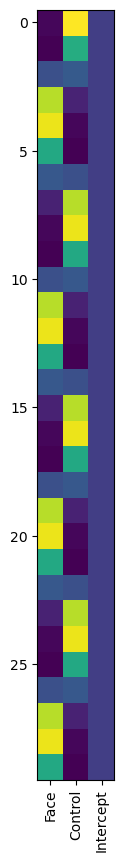

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(design_matrix[:30,:])
plt.xticks(np.arange(0,3), ['Face', 'Control', 'Intercept'])
plt.xticks(rotation=90)
plt.show()

# Task 9

In [48]:
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json


# Useful functions to define and import datasets from open neuro
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm

def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')

In [ ]:
# Create directories
sample_path = "dataset"
dataset_id = 'ds000105'
subject = '1'

mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

In [13]:
os.system("""openneuro-py download --dataset {} --include sub-{}/anat/* 
          --include sub-{}/func/sub-{}_task-objectviewing_run-01_bold.nii.gz 
          --include sub-{}/func/sub-{}_task-objectviewing_run-01_events.tsv
          --target_dir {}""".format(dataset_id, subject, subject, subject, subject, subject, bids_root).replace("\n", " "))

NameError: name 'dataset_id' is not defined

In [ ]:
reset_overlays()
load(op.join(bids_root, 'sub-1', 'func', 'sub-1_task-objectviewing_run-01_bold.nii.gz'))

In [ ]:
events_sub1 = pd.read_csv(op.join(bids_root, 'sub-1', 'func', 'sub-1_task-objectviewing_run-01_events.tsv'), sep='\t')

In [20]:
events_sub1

,onset,duration,trial_type
0,12.0,0.5,scissors
1,14.0,0.5,scissors
2,16.0,0.5,scissors
3,18.0,0.5,scissors
4,20.0,0.5,scissors
...,...,...,...
91,278.0,0.5,chair
92,280.0,0.5,chair
93,282.0,0.5,chair
94,284.0,0.5,chair


# Theoretical questions

### Question 1

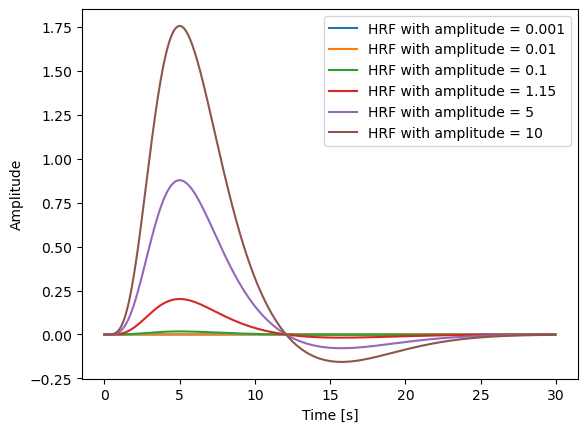

In [54]:
# Define our hrf
amplitudes = [0.001, 0.01, 0.1, 1.15, 5, 10]

time_len = 30
time = np.arange(0, time_len, TR / oversampling)

hrf_functions = []

for a in amplitudes:
    f = h(a, time)
    hrf_functions.append(f)
    plt.plot(time, f, label="HRF with amplitude = {}".format(a))


plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [55]:
b_estimate_list = []
for hrf in hrf_functions:
    convolved_signal = np.convolve(hrf, data["Signal"], mode='same')
    convolved_signal_undersampled = convolved_signal[::oversampling]
    sigma = 0.15
    noisy_response = convolved_signal_undersampled + np.random.normal(scale=sigma, size=len(convolved_signal_undersampled))

    # First we create the vectors used for the design matrix
    face_reg = np.array([])
    control_reg = np.array([])
    intercept = np.array([])

    events_keys = list(events.keys())

    for event in list_events:

        if event[0] == events_keys[0]:
            face_reg = np.append(face_reg, bank_of_signals[event[0]]) 
            control_reg = np.append(control_reg, bank_of_signals['Idle'])
        elif event[0] == events_keys[1]:
            control_reg = np.append(control_reg, bank_of_signals[event[0]])
            face_reg = np.append(face_reg, bank_of_signals['Idle']) 

        intercept = np.append(intercept, bank_of_signals['Intercept'])

    face_reg = face_reg/events[events_keys[0]]['Amplitude']
    control_reg = control_reg/events[events_keys[1]]['Amplitude']
    # Create the matrix out of these vectors
    design_matrix = np.column_stack((ds_face_reg, ds_control_reg, ds_intercept_reg))
    design_matrix_star = np.matmul(np.linalg.inv(np.matmul(np.transpose(design_matrix),design_matrix)), np.transpose(design_matrix))
    b_estimate = np.matmul(design_matrix_star, noisy_response) 
    b_estimate_list.append(b_estimate)
    


In [56]:
print(b_estimate_list)

[array([ 0.00242036,  0.00191494, -0.01976943]), array([ 0.00862435,  0.00233758, -0.00230159]), array([ 0.08764293,  0.02777525, -0.00269496]), array([1.0001245 , 0.30026844, 0.00168984]), array([4.34566665, 1.3028684 , 0.01967767]), array([8.69271144, 2.60506623, 0.02077097])]


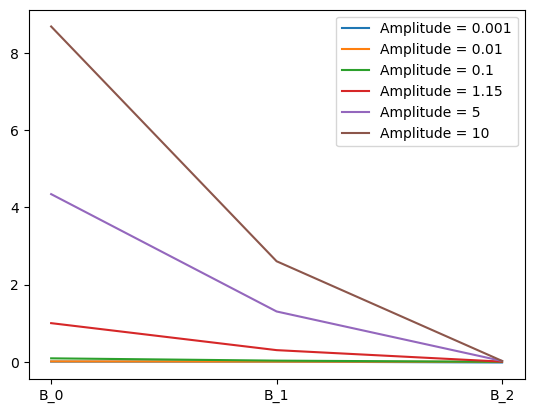

In [61]:
beta_labels = ["B_0", "B_1", "B_2"]
for idx in range(len(b_estimate_list)):
    plt.plot(beta_labels, b_estimate_list[idx], label="Amplitude = {}".format(amplitudes[idx]))

plt.legend()
plt.show()

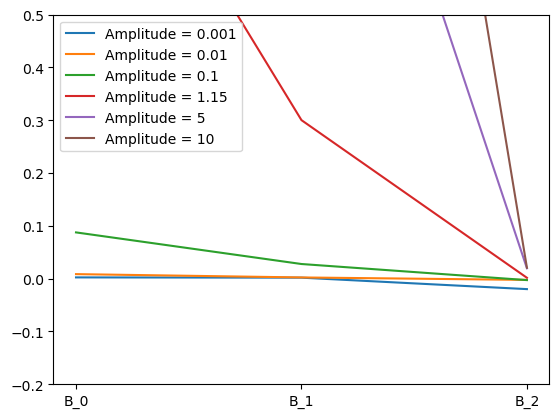

In [69]:
for idx in range(len(b_estimate_list)):
    plt.plot(beta_labels, b_estimate_list[idx], label="Amplitude = {}".format(amplitudes[idx]))

plt.legend()
plt.ylim(-0.2, 0.5)
plt.show()

For stronger signal amplitudes, the beta coeff increase proportionally, with very little increase for the B_2 coeff.

### Question 2

In [80]:
amplitude = 1.15
time_len = 30
time = np.arange(0, time_len, TR / oversampling)
hrf = h(a, time)

convolved_signal = np.convolve(hrf, data["Signal"], mode='same')
convolved_signal_undersampled = convolved_signal[::oversampling]

sigma_list = [0.001, 0.01, 0.15, 1, 5, 50, 100]
b_estimate_list = []
for sigma in sigma_list:
    noisy_response = convolved_signal_undersampled + np.random.normal(scale=sigma, size=len(convolved_signal_undersampled))

    # First we create the vectors used for the design matrix
    face_reg = np.array([])
    control_reg = np.array([])
    intercept = np.array([])

    events_keys = list(events.keys())

    for event in list_events:

        if event[0] == events_keys[0]:
            face_reg = np.append(face_reg, bank_of_signals[event[0]]) 
            control_reg = np.append(control_reg, bank_of_signals['Idle'])
        elif event[0] == events_keys[1]:
            control_reg = np.append(control_reg, bank_of_signals[event[0]])
            face_reg = np.append(face_reg, bank_of_signals['Idle']) 

        intercept = np.append(intercept, bank_of_signals['Intercept'])

    face_reg = face_reg/events[events_keys[0]]['Amplitude']
    control_reg = control_reg/events[events_keys[1]]['Amplitude']
    # Create the matrix out of these vectors
    design_matrix = np.column_stack((ds_face_reg, ds_control_reg, ds_intercept_reg))
    design_matrix_star = np.matmul(np.linalg.inv(np.matmul(np.transpose(design_matrix),design_matrix)), np.transpose(design_matrix))
    b_estimate = np.matmul(design_matrix_star, noisy_response) 
    b_estimate_list.append(b_estimate)

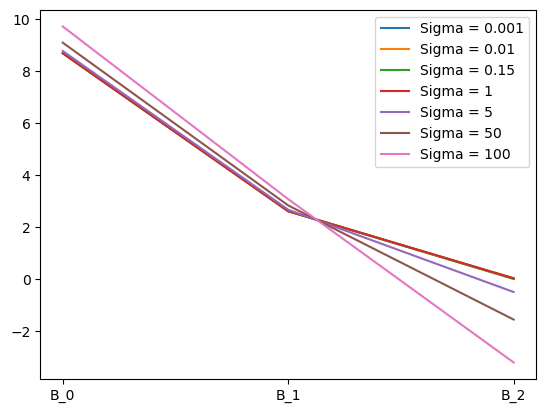

In [81]:
for idx in range(len(b_estimate_list)):
    plt.plot(beta_labels, b_estimate_list[idx], label="Sigma = {}".format(sigma_list[idx]))

plt.legend()
plt.show()

### Question 3